In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/NLP_Capgemini_2021/NLP @ X_HEC - 2K21/Cours 2 - Cleaning/")

In [ ]:
!pwd
!ls

/content/drive/MyDrive/NLP_Capgemini_2021/NLP @ X_HEC - 2K21/Cours 2 - Cleaning
'20210102_Master X-HEC_2021_Session 2_ business v3.pdf'   S2_2_XHEC2020.ipynb
 data							  S2_3_XHEC2020.ipynb
 requirements.txt					  Submission.ipynb
 S2_1_XHEC2020.ipynb


In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from textblob import TextBlob
from datetime import datetime
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

DATAPATH = "data/"

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Load and Explore Data

In [ ]:
# Try to name your data / dataframe explicitly. 
scrapped_data = pd.read_csv(DATAPATH+"resto_review.csv", usecols=range(1,7))

In [ ]:
# Take only a limited number of our reviews to increase speed / reduce process time
scrapped_data = scrapped_data.sample(30000)
# scrapped_data = scrapped_data.sample(frac=0.1)

In [ ]:
scrapped_data.head()

,resto,review_date,review_rating,review_title,review_text,review_link
16158,Meimo,21 July 2020,5,"Great, authentic Moroccan food","Amazing food, very authentic! The owner is suc...",https://www.tripadvisor.co.uk/ShowUserReviews-...
2914,Bekash Tandoori,11 June 2014,5,A Great Curry House & A Local Institution,The Bekash is something of a local institution...,https://www.tripadvisor.co.uk/ShowUserReviews-...
27440,The Glasshouse,3 June 2019,5,London Weekend,"We had been at Kew, and spotted the restaurant...",https://www.tripadvisor.co.uk/ShowUserReviews-...
8046,Imperial Arms,19 March 2019,5,Time to try another offer,This was a 50% off a big steak the usual excel...,https://www.tripadvisor.co.uk/ShowUserReviews-...
11418,La Plata Steakhouse,13 August 2018,4,Great service and steaks,"Good menu, wide range of steak sizes, which we...",https://www.tripadvisor.co.uk/ShowUserReviews-...


In [ ]:
print(scrapped_data.shape)
print(scrapped_data.describe())

(30000, 6)
       review_rating
count   30000.000000
mean        4.686533
std         0.788094
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000


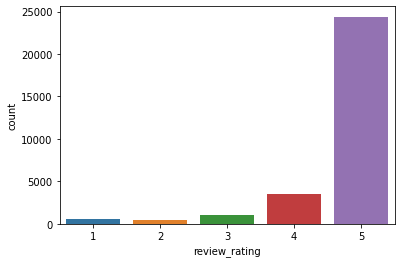

In [ ]:
sns.countplot(x=scrapped_data.review_rating)

## Feature Engineering

In [ ]:
months = ["January", "February", "March", "April", "May", "June", "July", 
          "August", "September", "October", "November", "December"]

scrapped_data['day'] = scrapped_data['review_date'].str[:2].str.strip()
scrapped_data['month'] = [months.index(x) + 1 for x in scrapped_data['review_date'].str[2:-4].str.strip()]
scrapped_data['year'] = scrapped_data['review_date'].str[-4:].str.strip()
scrapped_data['review_date'] = pd.to_datetime(scrapped_data[['year','month','day']])

## Preprocessing

In [ ]:
df = scrapped_data.copy()

#To lowercase
df.review_title = df.review_title.apply(lambda x: x.lower())
df.review_text = df.review_text.apply(lambda x: x.lower())

#Remove numbers
df.review_title = df.review_title.apply(lambda x: re.sub(r'\d+', '', x))
df.review_text = df.review_text.apply(lambda x: re.sub(r'\d+', '', x))

#Remove punctuation
def remove_punctuation(text):
    return ''.join([c for c in text if c not in punctuation])

df.review_title = df.review_title.apply(lambda x: remove_punctuation(x))
df.review_text = df.review_text.apply(lambda x: remove_punctuation(x))

#Remove ’s, ’t
df.review_title = df.review_title.apply(lambda x: x.replace('’s', '').replace('’t', ''))
df.review_text = df.review_text.apply(lambda x: x.replace('’s', '').replace('’t', ''))

#Remove stop words
stop_words = set(STOPWORDS)
def remove_stop_words(text):
    tokens = word_tokenize(text)
    return ' '.join([i for i in tokens if not i in stop_words])

df.review_title = df.review_title.apply(lambda x: remove_stop_words(x))
df.review_text = df.review_text.apply(lambda x: remove_stop_words(x)) 

df[['review_title', 'review_text']]

,review_title,review_text
16158,great authentic moroccan food,amazing food authentic owner lovely guy defini...
2914,great curry house local institution,bekash something local institution many years ...
27440,london weekend,kew spotted restaurant way back food service a...
8046,time try another offer,big steak usual excellent food great beer have...
11418,great service steaks,good menu wide range steak sizes well cooked o...
...,...,...
18719,excellent food excellent service,never tried nepalese food try new things say r...
9630,lefke night,want great food great night book lefke mixed m...
8339,delicious sunday lunch excellent service,went sunday lunch girlfriend weeks ago food ex...
20956,baby shower,ponte nuovo wonderfully warm friendly restaura...


In [ ]:
review_text = scrapped_data["review_text"].str.split()
review_title = scrapped_data["review_title"].str.split()

# Work on reviews

In [ ]:
#Homework function #1 
def basic_cleaning(corpus):

  #To lowercase
  corpus = [[x.lower() for x in line] for line in corpus]

  #Remove numbers
  corpus = [[re.sub(r'\d+', '', x) for x in line] for line in corpus]

  #Remove punctuation
  corpus = [[remove_punctuation(x) for x in line] for line in corpus]

  #Remove ’s, ’t
  corpus = [[x.replace('’s', '').replace('’t', '') for x in line] for line in corpus]

  #Remove stop words
  corpus = [[i for i in line if not i in stop_words] for line in corpus]

  #Remove empty strings
  corpus = [[i for i in line if i != ''] for line in corpus]
  
  return corpus

In [ ]:
review_text = basic_cleaning(review_text)
review_title = basic_cleaning(review_title)

## Tests of some stemmers

In [ ]:
# Stemming
stemmer = PorterStemmer()

def stemming(text):
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(i) for i in tokens])

df['review_title_stem'] = df.review_title.apply(lambda x: stemming(x))
df['review_text_stem'] = df.review_text.apply(lambda x: stemming(x))

df[['review_title_stem', 'review_text_stem']]

,review_title_stem,review_text_stem
16158,great authent moroccan food,amaz food authent owner love guy definit recom...
2914,great curri hous local institut,bekash someth local institut mani year solli g...
27440,london weekend,kew spot restaur way back food servic ambianc ...
8046,time tri anoth offer,big steak usual excel food great beer havent u...
11418,great servic steak,good menu wide rang steak size well cook order...
...,...,...
18719,excel food excel servic,never tri nepales food tri new thing say reall...
9630,lefk night,want great food great night book lefk mix meze...
8339,delici sunday lunch excel servic,went sunday lunch girlfriend week ago food exc...
20956,babi shower,pont nuovo wonder warm friendli restaur visit ...


## Lemmatize and Bigrams

In [ ]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()

def lemmatizing(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(i) for i in tokens])

def bigrams(text):
    tokens = word_tokenize(text)
    bigram = list(ngrams(tokens, 2))
    return bigram

df['review_title_lem'] = df.review_title.apply(lambda x: lemmatizing(x))
df['review_text_lem'] = df.review_text.apply(lambda x: lemmatizing(x))

df['review_title_bi'] = df.review_title.apply(lambda x: bigrams(x))
df['review_text_bi'] = df.review_text.apply(lambda x: bigrams(x))

df[['review_title_lem', 'review_text_lem', 'review_title_bi', 'review_text_bi']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


,review_title_lem,review_text_lem,review_title_bi,review_text_bi
16158,great authentic moroccan food,amazing food authentic owner lovely guy defini...,"[(great, authentic), (authentic, moroccan), (m...","[(amazing, food), (food, authentic), (authenti..."
2914,great curry house local institution,bekash something local institution many year s...,"[(great, curry), (curry, house), (house, local...","[(bekash, something), (something, local), (loc..."
27440,london weekend,kew spotted restaurant way back food service a...,"[(london, weekend)]","[(kew, spotted), (spotted, restaurant), (resta..."
8046,time try another offer,big steak usual excellent food great beer have...,"[(time, try), (try, another), (another, offer)]","[(big, steak), (steak, usual), (usual, excelle..."
11418,great service steak,good menu wide range steak size well cooked or...,"[(great, service), (service, steaks)]","[(good, menu), (menu, wide), (wide, range), (r..."
...,...,...,...,...
18719,excellent food excellent service,never tried nepalese food try new thing say re...,"[(excellent, food), (food, excellent), (excell...","[(never, tried), (tried, nepalese), (nepalese,..."
9630,lefke night,want great food great night book lefke mixed m...,"[(lefke, night)]","[(want, great), (great, food), (food, great), ..."
8339,delicious sunday lunch excellent service,went sunday lunch girlfriend week ago food exc...,"[(delicious, sunday), (sunday, lunch), (lunch,...","[(went, sunday), (sunday, lunch), (lunch, girl..."
20956,baby shower,ponte nuovo wonderfully warm friendly restaura...,"[(baby, shower)]","[(ponte, nuovo), (nuovo, wonderfully), (wonder..."


In [ ]:
def lemmatize_review(tokens):
  tokens = [[lemmatizer.lemmatize(i) for i in token] for token in tokens]
  return tokens

review_text = lemmatize_review(review_text)
review_title = lemmatize_review(review_title)

# TFIDF / BOW

In [ ]:
# You can use your own function to vectorize (TF or TF-IDF), but it is recommened to use libraries when possible.
# It is way more scalable and lot of functionnalities are implemented

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

df['review_text_prep'] = df['review_text_lem'].apply(lambda x: word_tokenize(x))
df['review_title_prep'] = df['review_title_lem'].apply(lambda x: word_tokenize(x))

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
corpus_review = [' '.join(sentence) for sentence in list(df['review_text_prep'])]
corpus_title = [' '.join(sentence) for sentence in list(df['review_title_prep'])]

In [ ]:
vect_review = vectorizer.fit_transform(corpus_review)

In [ ]:
feature_names = np.array(vectorizer.get_feature_names())
df_tfidf = pd.DataFrame(vect_review.todense(), columns=feature_names)

In [ ]:
df_tfidf_mean = df_tfidf.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
df_tfidf_mean.head()

,tfidf mean
food,0.050747
great,0.038527
service,0.037434
restaurant,0.034807
good,0.032822


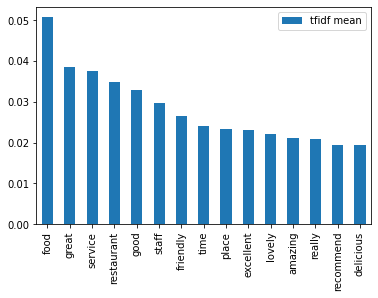

In [ ]:
df_tfidf_mean[:15].plot(kind='bar')
plt.show()

# WordClouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

plate_mask = 255 - np.array(Image.open(DATAPATH+"plate.png"))

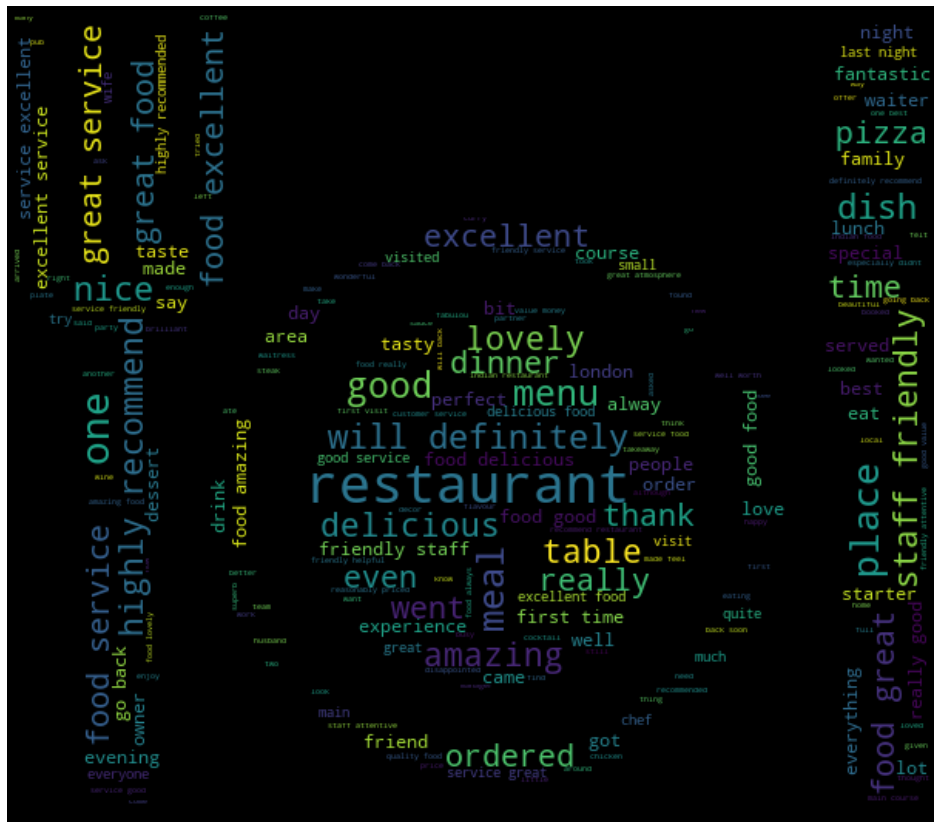

In [ ]:
def from_corpus_to_word_cloud(df):
  stword = set(STOPWORDS)
  text = " ".join(review_text for review_text in df)
  wordcloud = WordCloud(background_color="black", stopwords=stword, mask=plate_mask, width=800, height=400).generate(text)

  plt.figure(figsize=(20,15))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

from_corpus_to_word_cloud(corpus_review)

In [ ]:
df_keep = df[["resto", "review_date", "review_rating", "review_title_prep", "review_text_prep"]]
df_keep.to_csv("review_clean.csv")